# 1. Setup

## a. Run this first to setup django in this notebook

In [79]:
import os, django
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "backend.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

## b. Import django assets

In [80]:
from weather.models import *
from weather.tasks import *

## Import other libraries

In [81]:
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
from django_pandas.io import read_frame
import pytz
import matplotlib.pyplot as plt

# Stationary check
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

## b. Global variables (*)

In [82]:
dimensions = ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
entry_cycle = 24

# 2. Experiments

## a. Get new entries

In [83]:
update_entry.delay()

<AsyncResult: a3f2af21-43a1-4082-b3e6-fe5677047670>

## b. Check shape and nan values (whole dataset)

In [84]:
df = read_frame(Entry.objects.all())
print("Number of entry: ", df.shape[0])
print("Nan value check")
print(df.isna().sum())
print("Dataset overview")
print(df)

Number of entry:  63586
Nan value check
id      0
time    0
temp    0
dwpt    0
rhum    0
wdir    0
wspd    0
pres    0
coco    0
dtype: int64
Dataset overview
          id                      time  temp  dwpt   rhum   wdir  wspd  \
0          1 2017-01-01 00:00:00+00:00  23.0  23.0  100.0  350.0   7.6   
1          2 2017-01-01 01:00:00+00:00  25.0  23.1   89.0   20.0  11.2   
2          3 2017-01-01 02:00:00+00:00  28.0  21.1   66.0   40.0  11.2   
3          4 2017-01-01 03:00:00+00:00  30.0  21.1   59.0   30.0  14.8   
4          5 2017-01-01 04:00:00+00:00  31.0  20.0   52.0   20.0  13.0   
...      ...                       ...   ...   ...    ...    ...   ...   
63581  63582 2024-04-05 03:00:00+00:00  32.5  23.5   59.0  106.0   9.3   
63582  63583 2024-04-05 04:00:00+00:00  33.7  22.8   53.0  101.0   9.3   
63583  63584 2024-04-05 05:00:00+00:00  34.9  21.9   47.0   95.0   9.3   
63584  63585 2024-04-05 06:00:00+00:00  36.0  21.5   43.0   85.0  11.1   
63585  63586 2024-04-05 07

## c. Stationary check (Adfuller)

In [85]:
start_date = dt.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

In [86]:
dimension = "temp"
count = 24*10

### No difference

ADF Statistic: -8.510612426329823
p-value: 1.1702360267370123e-13
Critical Values:
   1%: -3.430680962484406
   5%: -2.861686273688728
   10%: -2.566847857504614


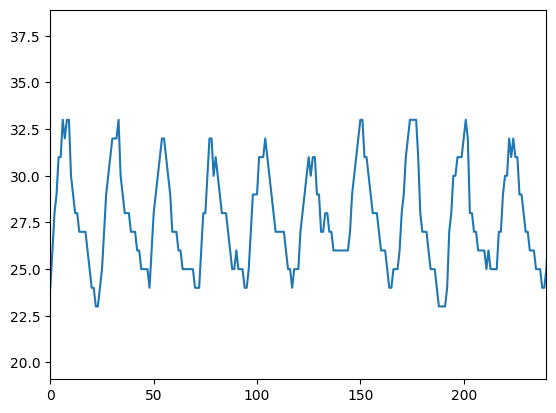

In [87]:
result_adf = adfuller(data[dimension])

# Print the results
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')
    
# Plotting temperature
plt.plot(data.index, data[dimension])
plt.xlim(data.iloc[0].name, data.iloc[count].name)
plt.show()

### First difference

First diff overview
1         2.0
2         2.0
3         1.0
4         2.0
5         0.0
         ... 
19803     2.3
19804     1.2
19805     1.2
19806     1.1
19807    -0.1
Name: temp, Length: 19807, dtype: object
ADF Statistic: -34.39654122670658
p-value: 0.0
Critical Values:
   1%: -3.4306809792356963
   5%: -2.861686281091792
   10%: -2.5668478614451353


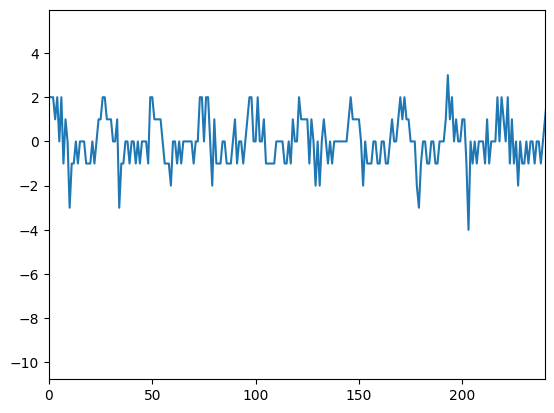

In [88]:
# Take the first differnce
first_diff = data[dimension].diff()[1:]

print("First diff overview")
print(first_diff)

result_adf = adfuller(first_diff)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

# Plotting first difference
plt.plot(first_diff.index, first_diff)
plt.xlim(0, count)
plt.show()



## c. Deciding SARIMA orders using ACF/PACF

### ACF

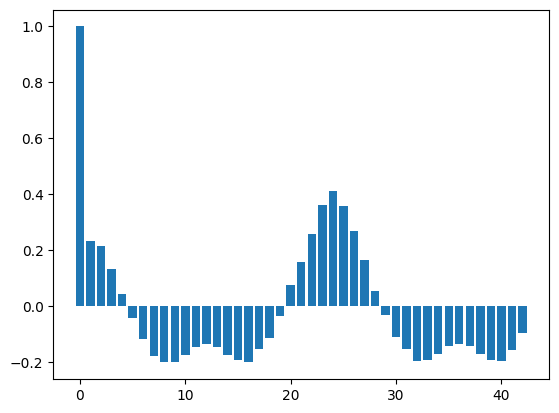

ACF Largest values:  [0.25891455 0.26878655 0.35957121 0.36276486 0.41260342 1.        ]  from hours  [22 26 25 23 24  0]


In [19]:
acf_result = sm.tsa.acf(first_diff)
num_lags = len(acf_result)
plt.bar(range(num_lags), acf_result[:num_lags])
plt.show()

# Get the indices of the five largest values
largest_indices = np.argsort(np.abs(acf_result))[-6:]
largest_values = acf_result[largest_indices]

print("ACF Largest significance: ", str(largest_values), " from hours ", str(largest_indices))

### PACF

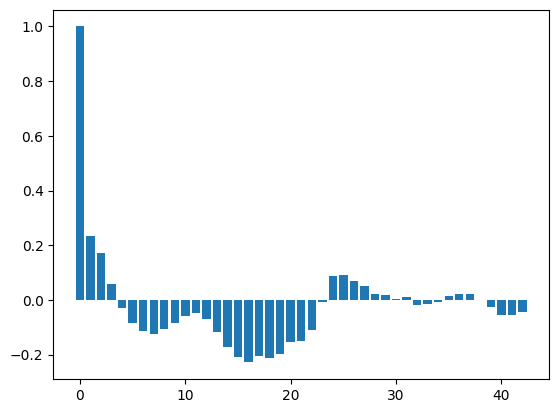

PACF Largest significance:  [-0.20403182 -0.20868406 -0.21173196 -0.22903985  0.23408861  1.        ]  from hours  [17 15 18 16  1  0]


In [20]:
pacf_result = sm.tsa.pacf(first_diff)
num_lags = len(pacf_result)
plt.bar(range(num_lags), pacf_result[:num_lags])
plt.show()

# Get the indices of the five largest values
largest_indices = np.argsort(np.abs(pacf_result))[-6:]
largest_values = pacf_result[largest_indices]

print("PACF Largest significance: ", str(largest_values), " from hours ", str(largest_indices))

# 3. Implementing SARIMA

## a. Normal SARIMA

### Splitting train/test sets

In [245]:
# Set how far into the future will the model forecast
forecast_limit = entry_cycle # 24 hours default

#data = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Chooose a start date
start_date = dt.datetime(2021, 1, 1).replace(tzinfo=pytz.UTC)
data = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
data = data[dimensions].astype(np.float64)

# Splitting train and test set
train_set = data.iloc[:math.floor(len(data) * 0.8)].copy(deep=True)
test_set = data.iloc[math.floor(len(data) * 0.8):].copy(deep=True)

# Preparing predictions set
predictions = test_set.iloc[:forecast_limit].copy(deep=True)
# predictions.reset_index(drop=True, inplace=True)

### Preview train/test set

In [246]:
train_set

,temp,dwpt,rhum,wdir,wspd,pres
0,23.0,16.1,65.0,20.0,11.2,1012.0
1,23.0,16.1,65.0,10.0,7.6,1013.0
2,24.0,16.0,61.0,10.0,7.6,1013.0
3,26.0,16.0,54.0,40.0,11.2,1013.0
4,28.0,16.0,48.0,40.0,11.2,1013.0
...,...,...,...,...,...,...
22850,31.0,26.9,79.0,280.0,24.1,1010.0
22851,32.0,27.0,75.0,280.0,20.5,1010.0
22852,32.0,26.1,71.0,290.0,14.8,1009.0
22853,34.0,25.1,60.0,280.0,18.4,1008.0


In [247]:
test_set

,temp,dwpt,rhum,wdir,wspd,pres
22855,35.0,26.1,60.0,250.0,20.5,1006.0
22856,35.0,26.1,60.0,270.0,14.8,1006.0
22857,34.0,25.1,60.0,270.0,22.3,1006.0
22858,33.0,25.0,63.0,260.0,22.3,1006.0
22859,32.0,26.1,71.0,250.0,25.9,1006.0
...,...,...,...,...,...,...
28564,33.7,22.8,53.0,101.0,9.3,1009.8
28565,34.9,21.9,47.0,95.0,9.3,1009.0
28566,36.0,21.5,43.0,85.0,11.1,1008.1
28567,35.9,21.4,43.0,66.0,13.0,1007.4


### SARIMA implementation

In [248]:
# Setting SARIMA order
non_seasonal_component = (0,1,0)
seasonal_component = (1, 0, 1, 24)

# Conducting SARIMA    
for dimension in tqdm(dimensions, desc="Processing dimensions..."):
    # Init SARIMAX model
    model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
    model_fit = model.fit()

    # Making predictions
    prediction = model_fit.forecast(forecast_limit)
    predictions.loc[:,dimension] = prediction
print("Done!")

Processing dimensions...: 100%|███████████████████████████| 6/6 [01:16<00:00, 12.75s/it]

Done!


### Prediction

In [249]:
predictions

,temp,dwpt,rhum,wdir,wspd,pres
22855,34.719301,24.640572,56.455110,297.756537,16.825113,1006.343006
22856,34.381770,24.697275,58.088881,298.110474,16.990663,1005.796184
22857,33.478469,24.734742,62.146095,293.851718,17.523673,1005.846921
22858,32.724939,24.677542,65.380181,290.683946,15.722577,1006.351918
22859,31.708220,24.839150,70.497712,288.272321,15.775449,1006.889498
22860,31.098433,24.766995,73.110391,288.292440,14.332404,1007.751669
22861,30.738714,24.650219,74.150300,287.614642,12.830579,1008.428993
22862,30.495773,24.743795,75.732693,280.531001,12.546666,1008.960347
22863,30.254134,24.851163,77.486583,284.210559,12.934864,1009.266151
22864,30.136350,24.845619,78.297526,284.902551,12.707175,1008.989254


In [250]:
test_set[:len(predictions)]

,temp,dwpt,rhum,wdir,wspd,pres
22855,35.0,26.1,60.0,250.0,20.5,1006.0
22856,35.0,26.1,60.0,270.0,14.8,1006.0
22857,34.0,25.1,60.0,270.0,22.3,1006.0
22858,33.0,25.0,63.0,260.0,22.3,1006.0
22859,32.0,26.1,71.0,250.0,25.9,1006.0
22860,31.0,26.0,75.0,250.0,18.4,1007.0
22861,30.0,26.0,79.0,260.0,20.5,1008.0
22862,30.0,27.0,84.0,240.0,24.1,1010.0
22863,29.0,27.0,89.0,240.0,24.1,1010.0
22864,28.0,26.9,94.0,250.0,22.3,1010.0


### Calculating residuals and error

In [251]:
residuals = test_set[:len(predictions)] - predictions
residuals = residuals
residuals

,temp,dwpt,rhum,wdir,wspd,pres
22855,0.280699,1.459428,3.544890,-47.756537,3.674887,-0.343006
22856,0.618230,1.402725,1.911119,-28.110474,-2.190663,0.203816
22857,0.521531,0.365258,-2.146095,-23.851718,4.776327,0.153079
22858,0.275061,0.322458,-2.380181,-30.683946,6.577423,-0.351918
22859,0.291780,1.260850,0.502288,-38.272321,10.124551,-0.889498
22860,-0.098433,1.233005,1.889609,-38.292440,4.067596,-0.751669
22861,-0.738714,1.349781,4.849700,-27.614642,7.669421,-0.428993
22862,-0.495773,2.256205,8.267307,-40.531001,11.553334,1.039653
22863,-1.254134,2.148837,11.513417,-44.210559,11.165136,0.733849
22864,-2.136350,2.054381,15.702474,-34.902551,9.592825,1.010746


In [252]:
entry_error = abs(residuals/ test_set[:len(predictions)])
error = entry_error.mean()
error = error*100
error

temp     5.082209
dwpt     6.355129
rhum    12.314621
wdir    13.908445
wspd    28.761688
pres     0.053592
dtype: float64

### Visualization

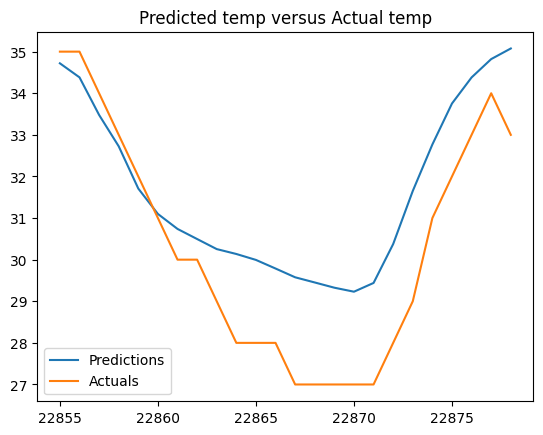

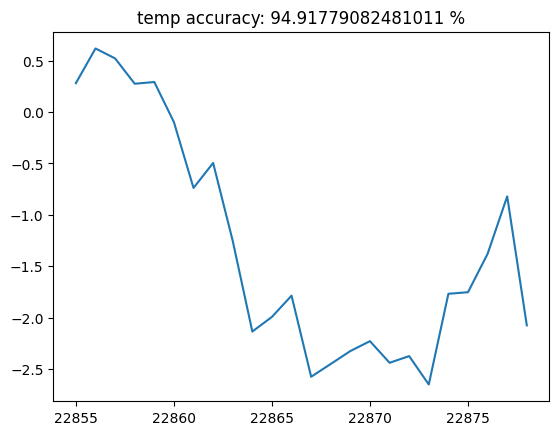

In [253]:
# Choose feature to visualize
d = 'temp'
limit = len(predictions)

# Predicted vs Actual
plt.plot(predictions[d].iloc[:limit], label='Predictions')
plt.plot(test_set[d].iloc[:limit], label='Actuals')
plt.legend()
plt.title('Predicted ' + d + ' versus Actual ' + d)
plt.show()

# Residuals
plt.plot(residuals[d])
plt.title(d + " accuracy: " + str(100 - abs(error[d])) + " %")
plt.show()

## Rolling SARIMA (Using actual values)

### SARIMA implementation

In [ ]:
# Setting SARIMA order
non_seasonal_component = (0,1,0)
seasonal_component = (1, 0, 1, 24)

for increment in tqdm(range(0,forecast_limit), desc="Predicting future entries..."):
    # Increment train_set
    train_set = data.iloc[:math.floor(len(data) * 0.8)+increment]
    
    # Conducting rolling SARIMA    
    for dimension in dimensions:
        # Init SARIMAX model
        model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
        model_fit = model.fit()

        # Making predictions
        prediction = model_fit.forecast()
        predictions.loc[increment,dimension] = prediction
print("Done!")

Predicting future entries...:  29%|██████▍               | 7/24 [08:30<20:24, 72.02s/it]

### Prediction's error

In [ ]:
residuals = test_set[:len(predictions)] - predictions
residuals = residuals
entry_error = abs(residuals/ test_set[:len(predictions)])
error = entry_error.mean()
error = error*100
error

### Visualization

In [ ]:
# Choose feature to visualize
d = 'temp'
limit = len(predictions)

# Predicted vs Actual
plt.plot(predictions[d].iloc[:limit], label='Predictions')
plt.plot(test_set[d].iloc[:limit], label='Actuals')
plt.legend()
plt.title('Predicted ' + d + ' versus Actual ' + d)
plt.show()

# Residuals
plt.plot(residuals[d])
plt.title(d + " accuracy: " + str(100 - abs(error[d])) + " %")
plt.show()

## Rolling SARIMA (Using predicted values)

In [179]:
print(predictions)
predictions.loc[19,'temp']

                        time  temp  dwpt   rhum   wdir  wspd    pres
0  2023-08-11 06:00:00+00:00  35.0  24.9   56.0  300.0  16.6  1007.0
1  2023-08-11 07:00:00+00:00  35.0  26.1   60.0  250.0  20.5  1006.0
2  2023-08-11 08:00:00+00:00  35.0  26.1   60.0  270.0  14.8  1006.0
3  2023-08-11 09:00:00+00:00  34.0  25.1   60.0  270.0  22.3  1006.0
4  2023-08-11 10:00:00+00:00  33.0  25.0   63.0  260.0  22.3  1006.0
5  2023-08-11 11:00:00+00:00  32.0  26.1   71.0  250.0  25.9  1006.0
6  2023-08-11 12:00:00+00:00  31.0  26.0   75.0  250.0  18.4  1007.0
7  2023-08-11 13:00:00+00:00  30.0  26.0   79.0  260.0  20.5  1008.0
8  2023-08-11 14:00:00+00:00  30.0  27.0   84.0  240.0  24.1  1010.0
9  2023-08-11 15:00:00+00:00  29.0  27.0   89.0  240.0  24.1  1010.0
10 2023-08-11 16:00:00+00:00  28.0  26.9   94.0  250.0  22.3  1010.0
11 2023-08-11 17:00:00+00:00  28.0  26.9   94.0  250.0  22.3  1009.0
12 2023-08-11 18:00:00+00:00  28.0  26.9   94.0  260.0  18.4  1009.0
13 2023-08-11 19:00:00+00:00  27.0

Decimal('29.0')

# Function to calculate accuracy

In [21]:
# Getting predictions that have been predicted over 24 hours ago
est_elapsed = (dt.datetime.utcnow() - dt.timedelta(hours=entry_cycle)).replace(tzinfo=pytz.utc)
predictions = Prediction.objects.filter(Q(prediction_time__lte=est_elapsed))

# Running loop to calculate accuracy of all predictions
for prediction in tqdm(predictions, desc="Calculating accuracy..."):
    pass

<QuerySet []>

# Rolling SARIMA (ineffective)

In [7]:
# train_set = (read_frame(Entry.objects.all())[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

start_date = datetime(2019, 1, 1)
train_set = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)

# Preparing predictions set
predictions = (read_frame(Entry.objects.all().order_by('-id')[:entry_cycle])[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
predictions = predictions.sort_values(by='time')
predictions.reset_index(drop=True, inplace=True)

# Converting from decimal to numpy float64
train_set[dimensions] = train_set[dimensions].astype(np.float64)
predictions[dimensions] = predictions[dimensions].astype(np.float64)

for index in range(0,len(predictions)):
    predictions.loc[index, 'time'] += dt.timedelta(hours=entry_cycle)
    
# Implement rolling SARIMAX

# Setting SARIMAX order
non_seasonal_component = (0,1,0)
seasonal_component = (1, 0, 1, 24)

# Conducting rolling SARIMA    
for index in tqdm(range(0,entry_cycle)):
    # Append newly predicted entries (Rolling)
    if index != 0:
        row_to_append = predictions.iloc[[index-1]]
        train_set = pd.concat([train_set, row_to_append], ignore_index=True)
    
    for dimension in dimensions:
        # Init SARIMAX model
        model = SARIMAX(np.asarray(train_set[dimension]), order=non_seasonal_component, seasonal_order=seasonal_component)
        model_fit = model.fit()

        # Making predictions
        prediction = model_fit.forecast()
        predictions.loc[index, dimension] = prediction


100%|████████████████████████████████████████████████| 24/24 [50:02<00:00, 125.11s/it]


In [30]:
predictions

,time,temp,dwpt,rhum,wdir,wspd,pres
0,2024-04-04 10:00:00+00:00,34.674628,21.757842,47.980764,42.039637,14.637410,1006.991213
1,2024-04-04 11:00:00+00:00,33.303306,22.174104,54.106896,40.808411,13.844925,1007.606838
2,2024-04-04 12:00:00+00:00,32.542064,22.385939,57.737553,38.187563,12.622192,1008.212644
3,2024-04-04 13:00:00+00:00,32.004396,22.574329,60.556833,35.461915,12.327889,1008.769428
4,2024-04-04 14:00:00+00:00,31.575220,22.812154,63.128387,33.829363,11.909321,1009.319566
5,2024-04-04 15:00:00+00:00,31.163749,23.044413,65.920817,34.696664,11.577724,1009.783805
6,2024-04-04 16:00:00+00:00,30.837037,23.156653,68.018967,34.475406,11.119053,1009.722441
7,2024-04-04 17:00:00+00:00,30.630219,23.273321,69.525157,38.317964,10.901011,1009.202393
8,2024-04-04 18:00:00+00:00,30.266395,23.383130,71.734188,37.958883,10.106811,1008.777375
9,2024-04-04 19:00:00+00:00,30.036876,23.393718,72.982042,38.862279,10.207509,1008.349168


In [31]:
train_set[len(train_set)-24:]

,time,temp,dwpt,rhum,wdir,wspd,pres
46066,2024-04-03 10:00:00+00:00,33.1,21.3,50.0,67.0,13.0,1006.9
46067,2024-04-03 11:00:00+00:00,31.9,22.3,57.0,72.0,11.1,1007.3
46068,2024-04-03 12:00:00+00:00,30.8,22.9,63.0,78.0,7.4,1007.8
46069,2024-04-03 13:00:00+00:00,29.8,23.3,68.0,81.0,7.4,1008.5
46070,2024-04-03 14:00:00+00:00,28.9,23.6,73.0,92.0,5.5,1009.2
46071,2024-04-03 15:00:00+00:00,27.9,23.9,79.0,187.0,3.7,1009.9
46072,2024-04-03 16:00:00+00:00,27.3,24.0,82.0,197.0,3.7,1009.7
46073,2024-04-03 17:00:00+00:00,26.8,24.1,85.0,203.0,3.7,1009.4
46074,2024-04-03 18:00:00+00:00,26.2,24.1,88.0,206.0,3.7,1009.1
46075,2024-04-03 19:00:00+00:00,25.8,24.0,90.0,208.0,3.7,1008.9


In [22]:
start_date = datetime(2019, 1, 1)
train_set = (read_frame(Entry.objects.filter(Q(time__gte=start_date)))[['time','temp','dwpt','rhum','wdir','wspd','pres']]).copy(deep=True)
train_set[dimensions] = train_set[dimensions].astype(np.float64)
train_set

,time,temp,dwpt,rhum,wdir,wspd,pres
0,2019-01-01 00:00:00+00:00,24.0,18.0,69.0,350.0,14.8,1014.0
1,2019-01-01 01:00:00+00:00,24.0,18.0,69.0,350.0,18.4,1014.0
2,2019-01-01 02:00:00+00:00,25.0,18.9,69.0,350.0,18.4,1014.0
3,2019-01-01 03:00:00+00:00,27.0,19.1,62.0,360.0,20.5,1014.0
4,2019-01-01 04:00:00+00:00,27.0,19.1,62.0,360.0,20.5,1013.0
...,...,...,...,...,...,...,...
46085,2024-04-04 05:00:00+00:00,34.8,21.8,47.0,83.0,9.3,1009.5
46086,2024-04-04 06:00:00+00:00,35.9,21.0,42.0,68.0,11.1,1008.7
46087,2024-04-04 07:00:00+00:00,36.0,21.1,42.0,54.0,11.1,1008.0
46088,2024-04-04 08:00:00+00:00,36.0,21.5,43.0,47.0,13.0,1007.2


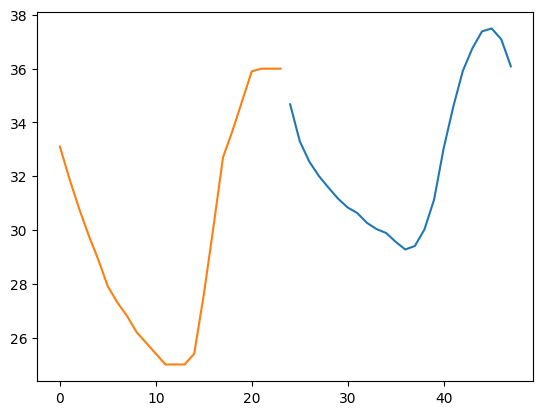

In [32]:
dimension = "temp"

plt.plot(range(24,48),predictions[dimension])
plt.plot(range(0,24),train_set[len(train_set)-24:][dimension])

In [71]:
residuals = 

28544    36.000000
28545    34.960047
28546    33.632776
28547    32.258463
28548    31.496814
28549    30.958965
28550    30.528368
28551    30.115584
28552    29.785685
28553    29.577767
28554    29.211297
28555    28.980574
28556    28.830043
28557    28.500077
28558    28.213512
28559    28.339516
28560    28.957285
28561    30.070677
28562    31.976137
28563    33.526765
28564    34.865752
28565    35.709735
28566    36.340254
28567    36.450807
Name: temp, dtype: float64

In [8]:
Entry.objects.latest()

ValueError: earliest() and latest() require either fields as positional arguments or 'get_latest_by' in the model's Meta.

In [13]:
train_set.iloc[-1].time



Timestamp('2024-04-04 12:00:00+0000', tz='UTC')

In [5]:
start_date = dt.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
start_date

datetime.datetime(2022, 1, 1, 0, 0, tzinfo=<UTC>)